<a href="https://colab.research.google.com/github/thiagolaitz/IA368-search-engines/blob/main/Project%2006/DPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dense Passage Retrieval (DPR)

In contrast to traditional sparse retrieval methods, DPR is based on dense vector representations of both the query and the documents, which capture the semantic meaning of the text and enable more effective matching between them. In this study, we will train two encoders using the MiniLM-L12-H384-uncased model from Microsoft, using 11,000 query-passages from the MSMarco dataset. The trained model will then be evaluated on the TREC-Covid 2020 dataset.

In [1]:
!nvidia-smi

Wed Apr 19 21:28:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries

In [1]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.9 MB/s eta 0:00:00


In [4]:
!pip install hnswlib -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install pyserini -q
!pip install faiss-cpu==1.7.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 111.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 2.9 MB/s eta 0:00:00


In [5]:
import os
import json

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup
)

from tqdm import tqdm
import hnswlib

# Base model

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained('microsoft/MiniLM-L12-H384-uncased')
text_encoder = AutoModel.from_pretrained('microsoft/MiniLM-L12-H384-uncased').to(device)
query_encoder = AutoModel.from_pretrained('microsoft/MiniLM-L12-H384-uncased').to(device)

# Dataset
The dataset we will use is a reduced version of the MSMARCO Triples Train dataset, which contains 11k triples consisting of a query, a relevant passage, and a non-relevant passage.

In [4]:
!wget https://storage.googleapis.com/unicamp-dl/ia368dd_2023s1/msmarco/msmarco_triples.train.tiny.tsv

--2023-04-19 21:29:15--  https://storage.googleapis.com/unicamp-dl/ia368dd_2023s1/msmarco/msmarco_triples.train.tiny.tsv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8076179 (7.7M) [text/tab-separated-values]
Saving to: ‘msmarco_triples.train.tiny.tsv’

msmarco_triples.tra 100%[===================>]   7.70M  --.-KB/s    in 0.1s    

2023-04-19 21:29:16 (77.4 MB/s) - ‘msmarco_triples.train.tiny.tsv’ saved [8076179/8076179]



In [6]:
# Get the last 1000 for validation
!tail -n 1000 msmarco_triples.train.tiny.tsv > validation.tsv

# Get the first 10000 for training
!head -n 10000 msmarco_triples.train.tiny.tsv > train.tsv

In [7]:
class CustomDataset(Dataset):
    """
    PyTorch dataset for processing text data in a specific format.

    Args:
        data_path (str): Path to the file containing the input data.
        tokenizer: Tokenizer object from the transformers library for encoding the text.
    """

    def __init__(self, data_path: str, tokenizer):
        self.tokenizer = tokenizer
        self.load_data(data_path)

    def load_data(self, data_path):
        """
        Reads the input file and stores the data in the `data` attribute as a list of tuples.
        Each tuple contains the query and the relevant document from a line of the file.

        Args:
            data_path (str): Path to the input file.
        """
        self.data = []
        with open(data_path, "r") as fin:
            for line in fin:
                query, pos_doc, _ = line.strip().split("\t")
                self.data.append((query, pos_doc))

    def __len__(self):
        """
        Returns the number of data samples in the dataset.

        Returns:
            int: Number of data samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, index):
        """
        Encodes a data sample at the given index using the tokenizer and returns it as a dictionary
        with the keys 'input_ids' and 'labels'.

        Args:
            index (int): Index of the data sample to encode.

        Returns:
            dict: Dictionary containing the encodings of the given data sample
            (query + passage).
        """
        query, doc = self.data[index]
        passage_encoding = self.tokenizer(
            doc,
            add_special_tokens=True,
            max_length=256,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        query_encoding = self.tokenizer(
            query,
            add_special_tokens=True,
            max_length=128,
            truncation=True,
            padding='max_length',
            return_tensors='pt',
        )
        return {
            'passage': passage_encoding,
            'query': query_encoding,
        }

# Training

Both encoders were trained simultaneously as there is only one loss function calculated based on both encoders. The primary objective was to increase the dot similarity between the query and passage embeddings. To achieve this, the "in-batch negatives" technique was utilized, which involves using negative examples from a batch of 32 pairs, where each pair consists of a query and its corresponding relevant passage. As a result, each query in the batch has one relevant passage and 31 negative passages. 

In [8]:
# Create train and eval datasets using a custom dataset class
train_dataset = CustomDataset("train.tsv", tokenizer)
eval_dataset = CustomDataset("validation.tsv", tokenizer)

# Define batch size and create data loaders for train and eval datasets
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)

In [9]:
# set up optimizers
optimizer_text = optim.AdamW(text_encoder.parameters(), lr=5e-5)
optimizer_query = optim.AdamW(query_encoder.parameters(), lr=5e-5)

# Define the number of steps to train
num_epochs = 20
total_steps = len(train_dataloader) * num_epochs
epoch_steps = len(train_dataloader)

# Create linear learning rate schedulers with warmup for text and query models
scheduler_text = get_linear_schedule_with_warmup(optimizer_text, num_warmup_steps=100, num_training_steps=total_steps)
scheduler_query = get_linear_schedule_with_warmup(optimizer_query, num_warmup_steps=100, num_training_steps=total_steps)

## Util functions

In [9]:
def mean_pooling(tokens, attention_mask):
    # tokens is a tensor of shape [batch_size, sequence_length, hidden_size]
    # attention_mask is a tensor of shape [batch_size, sequence_length]
    # attention_mask is used to indicate which elements in tokens to include in the mean pooling

    # apply the attention mask to the tokens
    masked_tokens = tokens * attention_mask.unsqueeze(-1)

    # calculate the sum of the masked tokens along the sequence length dimension
    summed_tokens = torch.sum(masked_tokens, dim=1)

    # calculate the count of non-masked elements in each sequence
    count_non_masked = torch.clamp(torch.sum(attention_mask, dim=1), min=1)

    # calculate the mean of the non-masked tokens
    mean_pooled = summed_tokens / count_non_masked.unsqueeze(-1)

    return mean_pooled


def get_loss(query_embeddings, passage_embeddings):
    similarity_matrix = torch.matmul(query_embeddings, passage_embeddings.t())
    # Each row corresponds to a query paired with $batch_size passages
    exponencial_similarity = torch.exp(similarity_matrix)

    # Compute the denominator of the DPR loss
    # The denominator is the sum of the exponencial similarity of each passage with the query
    # for each query in the batch
    denominator = torch.sum(exponencial_similarity, dim=1)

    # Compute the numerator of the DPR loss
    # The numerator is the exponencial similarity of the correct passage with the query
    # for each query in the batch. The correct passage is the passage with same index as the query
    numerator = torch.diag(exponencial_similarity)

    # Compute the DPR loss
    loss = -torch.log(numerator / denominator)

    return loss.mean()


def get_embeddings(batch):
    # Encode passages and queries using the text and query encoders
    text_outputs = text_encoder(
        input_ids=batch["passage"]['input_ids'].squeeze().to(device),
        attention_mask=batch["passage"]['attention_mask'].squeeze().to(device),
        token_type_ids=batch["passage"]['token_type_ids'].squeeze().to(device)
    )
    query_outputs = query_encoder(
        input_ids=batch["query"]['input_ids'].squeeze().to(device),
        attention_mask=batch["query"]['attention_mask'].squeeze().to(device),
        token_type_ids=batch["query"]['token_type_ids'].squeeze().to(device)
    )

    # Compute text and query embeddings using mean pooling
    text_embeddings = mean_pooling(text_outputs.last_hidden_state[:], batch["passage"]['attention_mask'].squeeze().to(device))
    query_embeddings = mean_pooling(query_outputs.last_hidden_state[:], batch["query"]['attention_mask'].squeeze().to(device))

    return text_embeddings, query_embeddings


## Training loop

In [11]:
# Create the "encoders" directory if it doesn't already exist
os.makedirs("encoders", exist_ok=True)

# Create empty lists to store training and evaluation loss history
train_loss_history = []
eval_loss_history = []

with tqdm(total=total_steps) as progress_bar:
    # Loop over the epochs
    for epoch_idx, epoch in enumerate(range(num_epochs)):
        text_encoder.train()
        query_encoder.train()
        
        # Initialize counters for the current epoch
        num_steps = 0
        train_loss = 0
        eval_loss = 0

        # Loop over the batches in the training data
        for batch in train_dataloader:
            # Get the normalized text and query embeddings for the current batch
            text_embeddings_normalized, query_embeddings_normalized = get_embeddings(batch)

            # Compute the combined loss from the text and query encoders
            loss = get_loss(query_embeddings_normalized, text_embeddings_normalized)

            optimizer_text.zero_grad()
            optimizer_query.zero_grad()

            loss.backward()

            optimizer_text.step()
            optimizer_query.step()

            scheduler_text.step()
            scheduler_query.step()

            train_loss += loss.item()

            # Update the progress bar message with the current iteration
            num_steps += 1
            progress_bar.set_description(f"Epoch: {epoch_idx + 1}/{num_epochs} | Steps: {num_steps}/{epoch_steps} | Loss: {loss.item():.3f}")

            progress_bar.update()
        
        # Set the text and query encoders to evaluation mode
        text_encoder.eval()
        query_encoder.eval()

        # Loop over the batches in the evaluation data
        for batch in eval_dataloader:
            with torch.no_grad():
                text_embeddings_normalized, query_embeddings_normalized = get_embeddings(batch)
                loss = get_loss(query_embeddings_normalized, text_embeddings_normalized)
                eval_loss += loss.item()

        # Save the trained encoders for the current epoch
        text_encoder.save_pretrained(f'./encoders/text_encoder_{epoch_idx}')
        query_encoder.save_pretrained(f'./encoders/query_encoder_{epoch_idx}')

        # Calculate the average training and evaluation loss for the current epoch
        avg_train_loss = train_loss / len(train_dataloader)
        avg_eval_loss = eval_loss / len(eval_dataloader)

        train_loss_history.append(avg_train_loss)
        eval_loss_history.append(avg_eval_loss)

        # Print the epoch number and the training and evaluation losses for the current epoch
        print('Epoch:', epoch + 1, 'Training Loss:', avg_train_loss, 'Validation Loss:', avg_eval_loss)


  0%|          | 0/6260 [00:00<?, ?it/s]

Epoch: 1 Training Loss: 0.63452563805583 Validation Loss: 0.12562221497910286
Epoch: 2 Training Loss: 0.10039542750797618 Validation Loss: 0.10912256247684127
Epoch: 3 Training Loss: 0.05239380485773944 Validation Loss: 0.128768237264012
Epoch: 4 Training Loss: 0.04778901417144595 Validation Loss: 0.1467320748633938
Epoch: 5 Training Loss: 0.0331177279115476 Validation Loss: 0.10995963784080232
Epoch: 6 Training Loss: 0.030218562771813177 Validation Loss: 0.08341194628701487
Epoch: 7 Training Loss: 0.021594933794845585 Validation Loss: 0.1307380741200177
Epoch: 8 Training Loss: 0.01972715982281344 Validation Loss: 0.12961397582330392
Epoch: 9 Training Loss: 0.01163267070753351 Validation Loss: 0.14789005591410387
Epoch: 10 Training Loss: 0.014946642006150843 Validation Loss: 0.11900528984915582
Epoch: 11 Training Loss: 0.010029001382896275 Validation Loss: 0.16447785188324815
Epoch: 12 Training Loss: 0.014753195821702222 Validation Loss: 0.12933017661578106
Epoch: 13 Training Loss: 0.0

## Loss plot

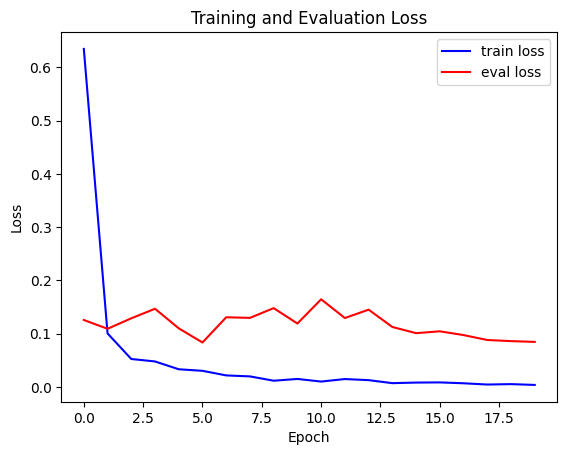

In [21]:
fig, ax = plt.subplots()

# Plot the train_loss_history as a blue line
ax.plot(train_loss_history, color='blue', label='train loss')

# Plot the eval_loss_history as a red line
ax.plot(eval_loss_history, color='red', label='eval loss')

ax.set_title('Training and Evaluation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.legend()

plt.show()

# TREC-Covid Dataset

In [10]:
# Corpus with all passages
!wget https://huggingface.co/datasets/BeIR/trec-covid/resolve/main/corpus.jsonl.gz
!gzip -cd corpus.jsonl.gz > corpus.jsonl

--2023-04-20 00:24:59--  https://huggingface.co/datasets/BeIR/trec-covid/resolve/main/corpus.jsonl.gz
Resolving huggingface.co (huggingface.co)... 13.35.7.102, 13.35.7.13, 13.35.7.28, ...
Connecting to huggingface.co (huggingface.co)|13.35.7.102|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/a8/10/a810e88b0e7b233be82b89c1fa6ec2d75efc6d55784c2ada9dcac8434a634f3a/e9e97686e3138eaff989f67c04cd32e8f8f4c0d4857187e3f180275b23e24e85?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27corpus.jsonl.gz%3B+filename%3D%22corpus.jsonl.gz%22%3B&response-content-type=application%2Fgzip&Expires=1682209500&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3JlcG9zL2E4LzEwL2E4MTBlODhiMGU3YjIzM2JlODJiODljMWZhNmVjMmQ3NWVmYzZkNTU3ODRjMmFkYTlkY2FjODQzNGE2MzRmM2EvZTllOTc2ODZlMzEzOGVhZmY5ODlmNjdjMDRjZDMyZThmOGY0YzBkNDg1NzE4N2UzZjE4MDI3NWIyM2UyNGU4NT9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSomcmVzcG

In [11]:
# Topics with all queries
!wget https://huggingface.co/datasets/BeIR/trec-covid/resolve/main/queries.jsonl.gz
!gzip -dc queries.jsonl.gz > queries.jsonl

--2023-04-20 00:25:08--  https://huggingface.co/datasets/BeIR/trec-covid/resolve/main/queries.jsonl.gz
Resolving huggingface.co (huggingface.co)... 13.35.7.102, 13.35.7.13, 13.35.7.28, ...
Connecting to huggingface.co (huggingface.co)|13.35.7.102|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/a8/10/a810e88b0e7b233be82b89c1fa6ec2d75efc6d55784c2ada9dcac8434a634f3a/9eadcc2cdf140addc9dae83648bb2c6611f5e4b66eaed7475fa5a0ca48eda371?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27queries.jsonl.gz%3B+filename%3D%22queries.jsonl.gz%22%3B&response-content-type=application%2Fgzip&Expires=1682209509&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3JlcG9zL2E4LzEwL2E4MTBlODhiMGU3YjIzM2JlODJiODljMWZhNmVjMmQ3NWVmYzZkNTU3ODRjMmFkYTlkY2FjODQzNGE2MzRmM2EvOWVhZGNjMmNkZjE0MGFkZGM5ZGFlODM2NDhiYjJjNjYxMWY1ZTRiNjZlYWVkNzQ3NWZhNWEwY2E0OGVkYTM3MT9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSomcmV

In [12]:
# Qrels with all relevances
!wget https://huggingface.co/datasets/BeIR/trec-covid-qrels/raw/main/test.tsv

--2023-04-20 00:25:09--  https://huggingface.co/datasets/BeIR/trec-covid-qrels/raw/main/test.tsv
Resolving huggingface.co (huggingface.co)... 13.35.7.102, 13.35.7.13, 13.35.7.28, ...
Connecting to huggingface.co (huggingface.co)|13.35.7.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 980831 (958K) [text/plain]
Saving to: ‘test.tsv’

test.tsv            100%[===================>] 957.84K  --.-KB/s    in 0.02s   

2023-04-20 00:25:10 (39.0 MB/s) - ‘test.tsv’ saved [980831/980831]



### Qrels

Create a Qrels file with the following format:


QID 0 DOC_ID RELEVANCE


In [13]:
with open("qrels.tsv", "w") as fout:
    with open("test.tsv", "r") as fin:
        for idx, line in enumerate(fin):
            if idx != 0:
                qid, doc_id, relevance = line.strip().split("\t")
                fout.write(f"{qid}\t0\t{doc_id}\t{relevance}\n")

### Topics

Load the queries to be used during our evaluation.

In [14]:
topics = []

with open("queries.jsonl", "r") as fin:
    for line in fin:
        query = json.loads(line)
        topics.append((query["_id"], query["text"]))

### Corpus



In [15]:
corpus = []

with open("corpus.jsonl", "r") as fin:
    for line in fin:
        doc = json.loads(line)
        corpus.append((doc["_id"], f"{doc['title']}. {doc['text']}"))

### Embeddings

The embeddings obtained from the passage and query texts using the mean pooling strategy will be used for search. The embeddings represent a compressed version of the input texts, where each embedding corresponds to a unique representation of the original text. 

In [16]:
# Tokenizes input texts and returns PyTorch tensors with special tokens,
# padding and truncation
def tokenize(texts, max_length=256):
    return tokenizer(
        texts,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )


# Computes the passage embeddings using the mean pooling strategy
def get_passage_embeddings(passages):
    tokenized = tokenize(passages)
    with torch.no_grad():
        text_outputs = text_encoder(
            input_ids=tokenized['input_ids'].squeeze().to(device),
            attention_mask=tokenized['attention_mask'].squeeze().to(device),
        )
        embeddings = mean_pooling(text_outputs.last_hidden_state[:], tokenized['attention_mask'].squeeze().to(device))
        return embeddings


# Computes the query embeddings using the mean pooling strategy
def get_query_embeddings(queries):
    tokenized = tokenize(queries, max_length=128) 
    with torch.no_grad():
        text_outputs = query_encoder(
            input_ids=tokenized['input_ids'].squeeze().to(device),
            attention_mask=tokenized['attention_mask'].squeeze().to(device),
        )
        embeddings = mean_pooling(text_outputs.last_hidden_state[:], tokenized['attention_mask'].squeeze().to(device))
        return embeddings

In [17]:
# Compute the queries embeddings in batches
topics_batches = [topics[i:i+32] for i in range(0, len(topics), 32)]
topics_embeddings = []

for batch in topics_batches:
    queries = [text[1] for text in batch]
    ids = [text[0] for text in batch]
    # Gets the queries embeddings
    queries_embeddings = get_query_embeddings(queries)
    # Gets the tuples made of (id, embedding)
    topics_embeddings.extend(list(zip(ids, queries_embeddings)))

In [18]:
# Compute the passages embeddings in batches
corpus_batches = [corpus[i:i+32] for i in range(0, len(corpus), 32)]
corpus_embeddings = []

for batch in tqdm(corpus_batches, desc="Generating corpus embeddings"):
    passages = [text[1] for text in batch]
    ids = [text[0] for text in batch]
    # Gets the passage embeddings
    passages_embeddings = get_passage_embeddings(passages)
    # Get the tuples made of (id, embedding)
    corpus_embeddings.extend(list(zip(ids, passages_embeddings)))

Generating corpus embeddings: 100%|██████████| 5355/5355 [15:42<00:00,  5.68it/s]


# Approximate Nearest Neighbor Search

In the context of Dense Passage Retrieval (DPR), Approximate Nearest Neighbor (ANN) search is a technique used to efficiently search for relevant passages. ANN search involves creating an index of the embeddings of the passages in the corpus. This index allows for fast retrieval of the most similar embeddings to a given query embedding. The search is approximate because the nearest neighbor is not guaranteed to be the exact nearest neighbor, but it is close enough for practical purposes.

In [30]:
# Set up the index
dim = 384  # Dimension of the feature vector
num_elements = len(corpus_embeddings)  # Number of elements in the dataset
index = hnswlib.Index(space='l2', dim=dim)  # Use L2 distance as the distance metric

# Add the data to the index
index.init_index(max_elements=num_elements, ef_construction=100, M=16)
index.add_items([doc[1].cpu().numpy() for doc in corpus_embeddings])

### ANN Run

This function is responsible for creating a RUN file in the TREC format:

QID Q0 DOC_ID RANK SCORE LABEL

In [31]:
def get_run(path: str, topics: list, top_k: int, doc_ids: list):
    """
    This function writes a TREC run in the given path.
    Args:
        path: the path to save the run
        topics: a list with [(id, embedding)] of queries for evaluating
        top_k: number of passages to retrieve
    """
    with open(path, 'w') as fout:
        for id, query in tqdm(topics, desc="Running queries"):
            query_np = query.cpu().numpy()  # Convert the tensor to a numpy array
            labels, distances = index.knn_query(query_np, k=top_k)  # Find the top_k nearest neighbors to the query
            rank = 1
            for idx, distance in zip(labels[0], distances[0]):
                fout.write(f"{id}\tQ0\t{doc_ids[idx]}\t{rank}\t{1/rank}\tDPR\n")
                rank += 1

In [32]:
get_run("run_DPR.tsv", topics_embeddings, 1000, [doc[0] for doc in corpus_embeddings])

Running queries:   0%|          | 0/50 [00:00<?, ?it/s]

## Results

In [34]:
!python -m pyserini.eval.trec_eval -c -m ndcg_cut.10 -mmap -l 2 qrels.tsv run_DPR.tsv

jtreceval-0.0.5-jar-with-dependencies.jar: 1.79MB [00:00, 6.33MB/s]                
Running command: ['java', '-jar', '/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar', '-c', '-m', 'ndcg_cut.10', '-mmap', '-l', '2', 'qrels.tsv', 'run_DPR.tsv']
Results:
map                   	all	0.0544
ndcg_cut_10           	all	0.3922


# Exhaustive search

 In the context of information retrieval, an exhaustive search would involve examining every passage in the corpus to find the ones that are most relevant to a given query. However, an exhaustive search can be extremely time-consuming and resource-intensive, especially for large-scale data sets

## Exhaustive Run

In [42]:
def exhaustive_search(queries, passages, top_k):
    """
    Perform an exhaustive search of all queries and passages, returning the top-k
    passages for each query.
    Args:
        queries (list): A list of tuples, where each tuple contains a query ID and
        a query embedding tensor.
        passages (list): A list of tuples, where each tuple contains a passage ID
        and a passage embedding tensor.
        top_k (int): The number of top passages to return for each query. 
    Yields:
        list: A list of the top-k passages for each query. Each element in the list
        is a tuple containing the query ID, the passage ID, and the similarity score
        between the query and the passage.
    """
    for q_id, q_emb in tqdm(queries, desc="Exhaustive Search"):
        results = []
        for p_id, p_emb in passages:
            dot_product = torch.dot(q_emb, p_emb).cpu().numpy()
            results.append((q_id, p_id, dot_product))
        results.sort(key=lambda x: x[2], reverse=True)
        yield results[:top_k]



def get_run_exaustive(path: str, topics: list, corpus: list, top_k: int):
    """
    This function writes a TREC run in the given path.
    Args:
        path: the path to save the run
        topics: a list with [(id, embedding)] of queries for evaluating
        top_k: number of passages to retrieve
    """
    with open(path, 'w') as fout:
        # Find the top_k nearest neighbors to the query
        for results in exhaustive_search(topics, corpus, top_k):
            rank = 1
            for qid, doc_id, score in results:
                fout.write(f"{qid}\tQ0\t{doc_id}\t{rank}\t{score}\tDPR\n")
                rank += 1

In [43]:
get_run_exaustive("run_DPR_exhaustive.tsv", topics_embeddings, corpus_embeddings, 1000)

Exhaustive Search: 100%|██████████| 50/50 [06:38<00:00,  7.97s/it]


## Results

In [44]:
!python -m pyserini.eval.trec_eval -c -m ndcg_cut.10 -mmap -l 2 qrels.tsv run_DPR_exhaustive.tsv

/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar already exists!
Skipping download.
Running command: ['java', '-jar', '/root/.cache/pyserini/eval/jtreceval-0.0.5-jar-with-dependencies.jar', '-c', '-m', 'ndcg_cut.10', '-mmap', '-l', '2', 'qrels.tsv', 'run_DPR_exhaustive.tsv']
Results:
map                   	all	0.0512
ndcg_cut_10           	all	0.3452
